<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/DLL30_DZ9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Рекуррентные сети 4 Механизи внимания»

Преподаватель: Даниил Корбут, Алексей Миронов, Татьяна Булгакова, Светлана Медведева, Артём Качалкин, Никита Селин

Возьмите англо-русскую пару фраз (www.manythings.org....org/anki/)

1. Обучите на них seq2seq with attention:
  *  на основе скалярного произведения
  *  на основе mlp

2. Оцените полученное качество


# Импорт библиотек

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [4]:
from google.colab import drive
from google.colab import files

In [5]:
from io import open
import unicodedata
import string
import re
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from itertools import product
plt.switch_backend('agg')
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка датасета

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip '/content/drive/MyDrive/rus-eng.zip'

Archive:  /content/drive/MyDrive/rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [9]:
!tail rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

#2. Параметры

In [10]:
SEED = 1234
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=='cpu':
  torch.manual_seed(SEED)
else:
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#3. Мета - параметры

In [11]:
SOS_token = 0
EOS_token = 1
lang1 = 'eng'
lang2 = 'rus'
MAX_LENGTH = 10 # Максимальное к-во токенов в предложении

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)
rnn_types           = [nn.LSTM, nn.GRU]
attn_types          = ['lection', 'scalar', 'mlp']
cols                = ['RNN_Type', 'attn_types', 'Loss', 'perplexity', 'learning_time']
PATH               = '/content/drive/My Drive/dz9_'

# 4. Пользовательские функции

## 4.1. Подготовка датасета

In [12]:
class Lang:
    """Грануляция на уровне слов. name - название языка.
    3 вида словарей в классе - Word2index ( слово-индекс), index2word (наоборот) и word2count (слово и кол-во его применений).
    2 метода - добавить слово и добавить предложение.
    При этом, если слово не встречалось ранее, оно добавляется во все словари.
    Если встречалось - значение словаря word2count для данного слова увеличивается на 1"""
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [13]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """Переводит символы Юникода в формат Ascii"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [14]:
def normalizeString(s):
    """Переводит в нижний регистр, убирает пробелы слева и справа.
    Добавляет пробел перед .!?, чтобы выделить знаки в отдельные токены.
    Все симводы, помимо букв и .!?, заменяет на пробелы"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [15]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Открывает файл для чтения, испольхуя кодировку utf8,
    # Убирает пробелы слева и справа,
    # делит на строки по '\n'
    lines = open('rus.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Каждую строку разделяет на части с использованием табуляции, в полученном списке использует 2 первых элемента
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines] #

    # создает экземпляры класса Lang для обоих языков, при необходимости
    # Можно использовать реверсирование, т.е поменять исходный язык и яык перевода местами
    # подготавливает пары предложений
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [16]:
def filterPair(p, prefixes):
    """Вспомогательная функция: разбивает строку на токены, используя знак пробела,
    Определяет число токенов  в строке для каждого предложения из пары.
    Проверяет, что их число не первышает MAX_LENGTH.
    Проверяет, что предложение на английском начинается с одного из eng_prefixes.
    Возвращает результат всех проверок (True или False)"""
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(prefixes)

In [17]:
def filterPairs(pairs, prefixes):
    """Вспомогательная функция - оставляем только те предложения, где число текенов не более 10"""
    return [pair for pair in pairs if filterPair(pair, prefixes)]

In [18]:
def prepareData(lang1, lang2, prefixes, reverse=False):
    """Функция для поготовки датасета"""
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, prefixes)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [19]:
def indexesFromSentence(lang, sentence):
    """переводит преложение в последовательность индексов слов"""
    return [lang.word2index[word] for word in sentence.split(' ')]

In [20]:
def tensorFromSentence(lang, sentence):
    """превращает последовательность индексов слов предложения в тензор"""
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    # добавляем еще одну размерность
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [21]:
def tensorsFromPair(pair, input_lang, output_lang):
    """Готовит тензоры из последовательностей токенов входного и выходного предложений"""
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## 4.2. Обучение модели

In [22]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = rnn_type(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [23]:
# Изменим класс декодера. Доюбавим, помимо механизма внимания, еще и возможность выбора типа rnn ячейки
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        # self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_type_name = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # attn_weights = F.softmax(
        #     self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # Механизм внимания изменяется здесь
        if  self.rnn_type_name == 'LSTM':
            attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        else:
             attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        # output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
# Создадим новый класс декодера, в котором изменим механизм внимания на scalar
class AttnDecoderRNN1(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN1, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # Механизм внимания изменяется здесь
        attn_weights = F.softmax((embedded[0] @ encoder_outputs.T)/self.max_length**0.5, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        # output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
# Создадим новый класс декодера, в котором изменим механизм внимания на mlp
class AttnDecoderRNN2(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_type_name = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # Механизм внимания изменяется здесь
        if  self.rnn_type_name == 'LSTM':
            attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        else:
             attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.tanh(output)
        # output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [26]:
def train(input_tensor, target_tensor,
          encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length, rnn_type, teacher_forcing_ratio):

    """Выполняет итерацию обучения модели
    Args:
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    max_length=MAX_LENGTH - максимальное кол-во токенов  каждом предложении,
    rnn_type - тип RNN ячейки,
    n_layers - число скрытых слоев,
    teacher_forcing_ratio"""
    if rnn_type.__name__ == 'LSTM':
        encoder_hidden = (encoder.initHidden(), encoder.initHidden())
    else:
        encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    total_words = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            total_words += target_tensor[di].numel()

    else:
        # Without teacher forcing: use its own predictions as the next input

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            total_words += target_tensor[di].numel()
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    avg_loss = loss / total_words
    perplexity = torch.exp(avg_loss)
    return loss.item() / target_length, perplexity.item()

In [27]:
def asMinutes(s):
    """Вспомогательная функция перевода секунд  в минуты"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """ длительность итерации обучения"""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [28]:
def trainIters(pair_sentenses, encoder, decoder, learning_rate, n_iters,
               max_length, rnn_type, teacher_forcing_ratio, input_lan, output_lan,
               print_every=5000, plot_every=500):
    """выполняет обучение модели"""
    start               = time.time()
    print_loss_total = 0
    print_loss_avg = 0
    print_perplexity = 0

    encoder_optimizer = optim.Adam(encoder.parameters())
    decoder_optimizer = optim.Adam(decoder.parameters())

    training_pairs = [tensorsFromPair(random.choice(pair_sentenses),
                                      input_lan, output_lan)
                                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss, perplexity = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion,
                     max_length, rnn_type, teacher_forcing_ratio)

        print_loss_total += loss
        print_perplexity += perplexity

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_perplexity_avg = print_perplexity / print_every
            print_loss_total = 0
            print_perplexity = 0

            print('%s (%d %d%%) %.4f %.4f'  % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, print_perplexity_avg ))
    return print_loss_avg, print_perplexity_avg, timeSince(start, iter / n_iters)


In [29]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [30]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [31]:
def evaluateAndShowAttention(encoder2, decoder2, max_length, input_sentence):
    output_words, attentions = evaluate(
        encoder2, decoder2, input_sentence, max_length,
             rnn_type, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

## 4.3. Оценка модели

In [32]:
def evaluate(encoder, decoder, sentence, max_length,
             rnn_type, inp_lang, out_lang):
    """Оценка качества модели на паре предложений"""
    with torch.no_grad():
        input_tensor = tensorFromSentence(inp_lang, sentence)
        input_length = input_tensor.size()[0]

        if rnn_type.__name__ == 'LSTM':
            encoder_hidden = (encoder.initHidden(), encoder.initHidden())
        else:
            encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(out_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        # Здесь изменения
        return decoded_words, decoder_attentions[:di + 1]

In [37]:
def evaluateRandomly(pair_sen, encoder, decoder, max_length,
                     rnn_, in_lang, o_lang,  n=10):
    """Оценка качества модели на случайно отобранных n парах предложений"""
    for i in range(n):
        pair = random.choice(pair_sen)
        print('>', pair[0])
        print('=', pair[1])
        # здесь изменения
        output_words, _ = evaluate(encoder, decoder, pair[0], MAX_LENGTH,
                                rnn_, in_lang, o_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Перплексия (perplexity) - это метрика, которая используется для оценки качества модели языковой модели. Она вычисляется как экспонента средней перекрестной энтропии (cross-entropy) на тестовом наборе данных.

In [39]:
def test_model(max_length, hidden_size = 256,
               learn_rate = 0.006, prefixes=eng_prefixes, reverse=False,
               teach_force_ratio = 0.5, attn_type = 'lection',
               num_iters = 500, every = 100, num_file = 998):
        """ Функция для обучения и оценки модели"""
        # Инициируем энкодер и декодер
        encoder2 = EncoderRNN(input_lang.n_words, hidden_size, rnn_type
                               ).to(device)
        if attn_type == 'lection':
          decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type
                                ).to(device)
        elif attn_type == 'scalar':
          decoder2 = AttnDecoderRNN1(hidden_size, output_lang.n_words, rnn_type
                                ).to(device)
        elif attn_type == 'mlp':
          decoder2 = AttnDecoderRNN2(hidden_size, output_lang.n_words, rnn_type
                                ).to(device)
        print(f'{rnn_type.__name__}, {attn_type} \n\ntraining')
        print('===========================')
        # выполняем обучение модели, считаем ф-ю потерь
        loss_, perplexity, learning_time = trainIters(pair_s, encoder2, decoder2, learn_rate, num_iters,
                          max_length, rnn_type, teach_force_ratio,
                          input_lang, output_lang, every)

        print('\nevaluation\n')
        # Выполняем оценку обученной модели
        evaluateRandomly(pair_s, encoder2, decoder2, max_length,
                         rnn_type, input_lang, output_lang)
        print('----------------------------------------------------------------------')
        string          = [rnn_type.__name__, attn_type, loss_, perplexity,  learning_time]
        # string          = [rnn_type.__name__, attn_type, loss_, perplexity.detach().cpu().item(),  learning_time]
        df.loc[len(df)] = string
        file_name       = PATH + str(num_file) + '.csv'
        df.to_csv(file_name)
        evaluateAndShowAttention(encoder2, decoder2, max_length,'на следующеи неделе я иду на концерт .')

# 5. Эксперименты

In [35]:
# Инициируем экземпляры классов для обоих языков, готовим датасет
print('Подготовка датасета:')
print('----------------------------------------------------------------------')
input_lang, output_lang, pair_s = prepareData(lang1, lang2, prefixes=eng_prefixes, reverse=True)
# Это пример пары предложений
print(random.choice(pair_s))
# датафрейм для сохранения результатов обучения разных моделей
df = pd.DataFrame(columns=cols)

Подготовка датасета:
----------------------------------------------------------------------
Reading lines...
Read 487600 sentence pairs
Trimmed to 28240 sentence pairs
Counting words...
Counted words:
rus 10119
eng 4289
['на следующеи неделе я иду на концерт .', 'i am going to a concert next week .']


## 5.1. GRU, attention_type='lection'

Эксперименты с моделями:
----------------------------------------------------------------------
GRU, lection 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

2m 56s (- 55m 57s) (1000 5%) 3.3479 111.4404
5m 39s (- 50m 59s) (2000 10%) 2.9602 49.9226
8m 27s (- 47m 54s) (3000 15%) 2.7549 37.2180
11m 24s (- 45m 36s) (4000 20%) 2.6619 38.3877
14m 12s (- 42m 37s) (5000 25%) 2.5404 33.5883
17m 0s (- 39m 41s) (6000 30%) 2.5143 40.9352
19m 49s (- 36m 48s) (7000 35%) 2.3950 34.3124
22m 39s (- 33m 59s) (8000 40%) 2.2579 27.2153
25m 35s (- 31m 16s) (9000 45%) 2.2385 27.8002
28m 28s (- 28m 28s) (10000 50%) 2.1285 27.3719
31m 22s (- 25m 40s) (11000 55%) 2.1260 26.4493
34m 17s (- 22m 51s) (12000 60%) 2.0826 24.2290
37m 15s (- 20m 3s) (13000 65%) 2.0105 21.0548
40m 25s (- 17m 19s) (14000 70%) 1.9605 20.2969
43m 30s (- 14m 30s) (15000 75%) 1.9892 23.0604
46m 29s (- 11m 37s) (16000 80%) 1.9316 25.5542
49m 32s (- 8m 44s) (17000 85%) 1.8912 21.2280
52m 47s (- 5m 51s) (18000 90%) 1.8520 21.1936
56m 0s (- 2m 56s) (19000 95%) 1.8819 23.7619
59m 11s (- 0m 0s) (20000 100%) 1.8896 58.4242

evaluation

> вы зря тратите время .
= you re wasting time .
< you re wasting 

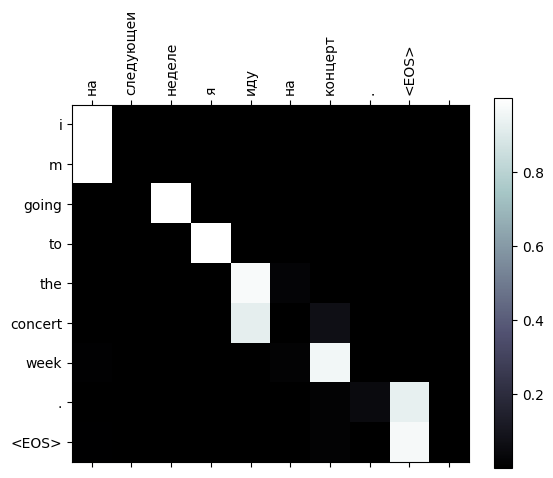

In [48]:
# Эксперименты для моделей с разными типами RNN ячеек (RNN, GRU, LSTM) и кол-вом скрытых состояний
print('Эксперименты с моделями:')
print('----------------------------------------------------------------------')
num_file = 1

rnn_type = nn.GRU
attn_type = 'lection'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=True, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 1000,
           num_file = num_file)



## 5.2. LSTM, attention_type='lection'

LSTM, lection 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

3m 12s (- 60m 51s) (1000 5%) 3.3348 123.4117
6m 30s (- 58m 38s) (2000 10%) 2.9360 40.8038
9m 52s (- 55m 55s) (3000 15%) 2.8374 37.2863
13m 11s (- 52m 45s) (4000 20%) 2.7171 32.1977
16m 33s (- 49m 40s) (5000 25%) 2.6604 32.8670
20m 10s (- 47m 4s) (6000 30%) 2.6125 34.5058
23m 35s (- 43m 49s) (7000 35%) 2.5009 30.5912
27m 4s (- 40m 37s) (8000 40%) 2.4452 30.3585
30m 30s (- 37m 17s) (9000 45%) 2.4376 28.0385
34m 1s (- 34m 1s) (10000 50%) 2.4187 36.4291
37m 32s (- 30m 43s) (11000 55%) 2.3281 26.3479
40m 57s (- 27m 18s) (12000 60%) 2.3171 26.0980
44m 24s (- 23m 54s) (13000 65%) 2.2601 22.8515
47m 54s (- 20m 31s) (14000 70%) 2.2533 28.5071
51m 23s (- 17m 7s) (15000 75%) 2.1557 27.0462
54m 59s (- 13m 44s) (16000 80%) 2.1676 22.6220
58m 32s (- 10m 19s) (17000 85%) 2.1247 21.6991
62m 13s (- 6m 54s) (18000 90%) 2.1071 22.0257
65m 50s (- 3m 27s) (19000 95%) 2.0765 24.3099
69m 29s (- 0m 0s) (20000 100%) 2.1403 25.9650

evaluation

> я человек а не машина .
= i m a man not a machine .
< i m not hun

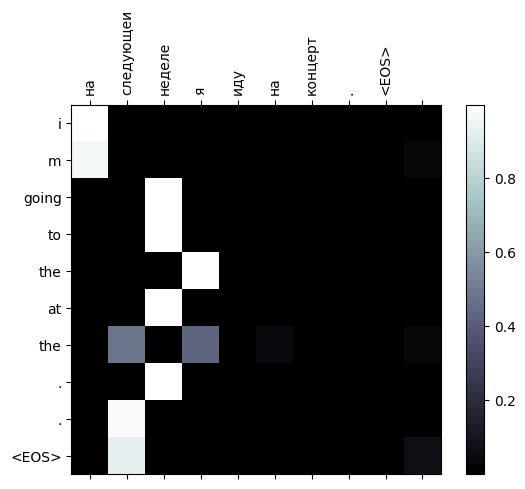

In [49]:
num_file = 2
rnn_type = nn.LSTM
attn_type = 'lection'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=True, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 1000,
           num_file = num_file)

## 5.3. GRU, attention_type='scalar'

GRU, scalar 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

2m 44s (- 52m 10s) (1000 5%) 3.2795 118.9144
5m 34s (- 50m 9s) (2000 10%) 2.9508 48.2588
8m 35s (- 48m 42s) (3000 15%) 2.8249 44.6144
11m 33s (- 46m 15s) (4000 20%) 2.6580 35.4920
14m 29s (- 43m 28s) (5000 25%) 2.5522 33.5813
17m 33s (- 40m 57s) (6000 30%) 2.4410 30.8780
20m 31s (- 38m 6s) (7000 35%) 2.3918 32.7803
23m 38s (- 35m 28s) (8000 40%) 2.3352 26.7488
26m 47s (- 32m 44s) (9000 45%) 2.2789 27.8628
29m 54s (- 29m 54s) (10000 50%) 2.2027 28.8046
33m 7s (- 27m 5s) (11000 55%) 2.1109 26.3447
36m 15s (- 24m 10s) (12000 60%) 2.1359 26.7006
39m 23s (- 21m 12s) (13000 65%) 2.1283 26.8682
42m 28s (- 18m 12s) (14000 70%) 2.1205 24.0456
45m 31s (- 15m 10s) (15000 75%) 2.0232 21.6205
48m 33s (- 12m 8s) (16000 80%) 1.9774 23.4195
51m 40s (- 9m 7s) (17000 85%) 1.9324 23.5938
54m 45s (- 6m 5s) (18000 90%) 1.9556 32.9269
57m 57s (- 3m 3s) (19000 95%) 1.9434 24.0650
61m 10s (- 0m 0s) (20000 100%) 1.8906 20.5674

evaluation

> мы наблюдаем .
= we re watching .
< we re finished . <EOS>

> я собир

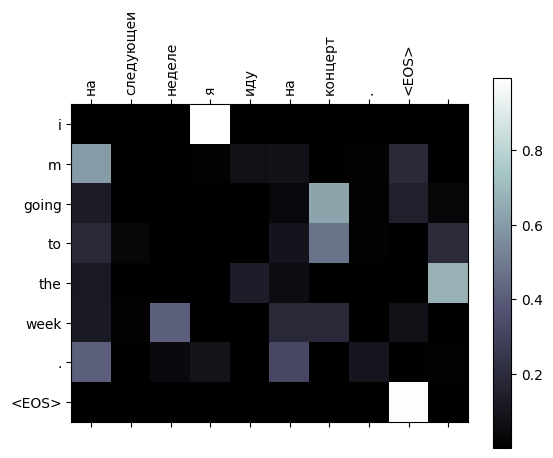

In [50]:
num_file = 3
rnn_type = nn.GRU
attn_type = 'scalar'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=True, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 1000,
           num_file = num_file)

## 5.4. LSTM, attention_type='scalar'

LSTM, scalar 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

3m 18s (- 62m 53s) (1000 5%) 3.2933 131.6364
6m 39s (- 59m 56s) (2000 10%) 3.0499 47.0830
10m 4s (- 57m 5s) (3000 15%) 2.9117 42.3212
13m 30s (- 54m 2s) (4000 20%) 2.8139 39.3702
16m 56s (- 50m 50s) (5000 25%) 2.7441 32.7714
20m 20s (- 47m 28s) (6000 30%) 2.6602 28.6020
23m 59s (- 44m 34s) (7000 35%) 2.5879 32.0662
27m 37s (- 41m 25s) (8000 40%) 2.5106 29.5922
31m 17s (- 38m 14s) (9000 45%) 2.5078 27.8312
34m 50s (- 34m 50s) (10000 50%) 2.4384 25.8173
38m 23s (- 31m 24s) (11000 55%) 2.5021 34.4338
42m 5s (- 28m 3s) (12000 60%) 2.4290 28.9168
45m 48s (- 24m 39s) (13000 65%) 2.3776 25.9982
49m 27s (- 21m 11s) (14000 70%) 2.3389 26.6495
53m 5s (- 17m 41s) (15000 75%) 2.3127 28.3302
56m 43s (- 14m 10s) (16000 80%) 2.2234 21.7836
60m 19s (- 10m 38s) (17000 85%) 2.2589 26.1291
64m 3s (- 7m 7s) (18000 90%) 2.1685 23.5593
67m 50s (- 3m 34s) (19000 95%) 2.2266 32.6819
71m 34s (- 0m 0s) (20000 100%) 2.1980 50.8979

evaluation

> я боюсь что не понимаю .
= i m afraid i don t understand .
< i m af

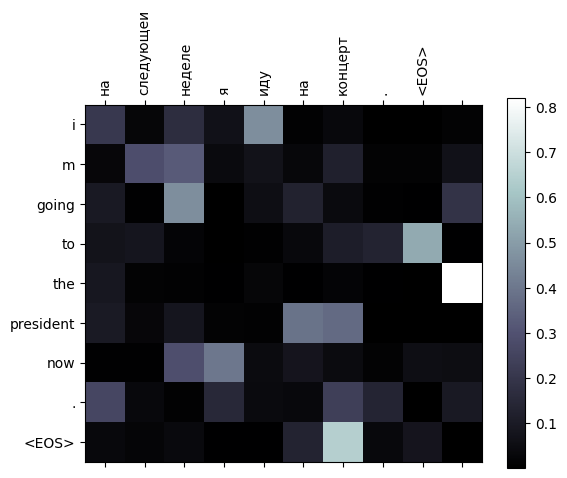

In [51]:
num_file = 4
rnn_type = nn.LSTM
attn_type = 'scalar'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=True, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 1000,
           num_file = num_file)

## 5.5. GRU, attention_type='mlp'

GRU, mlp 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

2m 43s (- 51m 39s) (1000 5%) 3.3491 112.4627
5m 33s (- 49m 57s) (2000 10%) 2.9817 64.8149
8m 22s (- 47m 26s) (3000 15%) 2.8291 47.2322
11m 23s (- 45m 33s) (4000 20%) 2.7199 39.3348
14m 19s (- 42m 57s) (5000 25%) 2.5359 31.8914
17m 16s (- 40m 18s) (6000 30%) 2.4713 31.7882
20m 16s (- 37m 39s) (7000 35%) 2.4034 32.7355
23m 16s (- 34m 54s) (8000 40%) 2.3034 26.5609
26m 23s (- 32m 15s) (9000 45%) 2.2808 30.1355
29m 29s (- 29m 29s) (10000 50%) 2.3003 31.3789
32m 28s (- 26m 34s) (11000 55%) 2.1749 30.9213
35m 25s (- 23m 37s) (12000 60%) 2.2064 37.8935
38m 24s (- 20m 40s) (13000 65%) 2.0606 23.1591
41m 22s (- 17m 43s) (14000 70%) 2.0036 23.3647
44m 17s (- 14m 45s) (15000 75%) 2.0295 27.8993
47m 23s (- 11m 50s) (16000 80%) 2.0270 28.4181
50m 33s (- 8m 55s) (17000 85%) 1.9778 27.6493
53m 47s (- 5m 58s) (18000 90%) 1.9779 29.5672
57m 18s (- 3m 0s) (19000 95%) 1.8831 20.0260
60m 42s (- 0m 0s) (20000 100%) 1.9167 25.0781

evaluation

> я тебе завидую .
= i m jealous of you .
< i m going you . <EOS

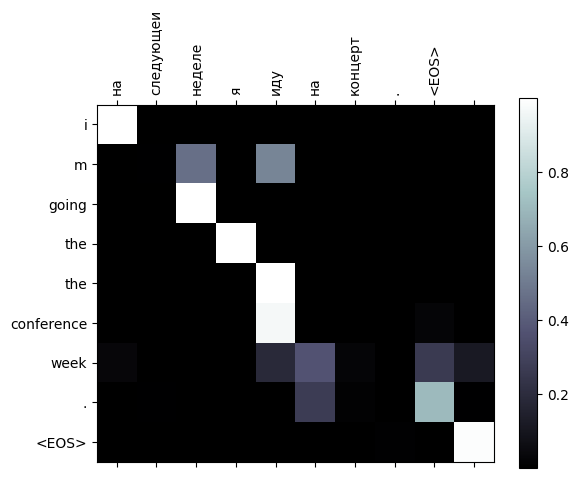

In [52]:
num_file = 5
rnn_type = nn.GRU
attn_type = 'mlp'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=True, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 1000,
           num_file = num_file)

## 5.6. LSTM, attention_type='mlp'

In [ ]:
num_file = 6
rnn_type = nn.LSTM
attn_type = 'mlp'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=True, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 1000,
           num_file = num_file)

LSTM, mlp 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

3m 39s (- 69m 22s) (1000 5%) 3.3918 143.3725
7m 15s (- 65m 23s) (2000 10%) 2.9810 44.6436
10m 43s (- 60m 46s) (3000 15%) 2.8673 40.4668
14m 23s (- 57m 33s) (4000 20%) 2.8184 36.6542
18m 4s (- 54m 14s) (5000 25%) 2.7061 33.5239
21m 46s (- 50m 47s) (6000 30%) 2.6672 32.4141
25m 30s (- 47m 21s) (7000 35%) 2.6374 35.5769
29m 13s (- 43m 50s) (8000 40%) 2.5533 30.2142
32m 51s (- 40m 9s) (9000 45%) 2.5389 32.5116
36m 31s (- 36m 31s) (10000 50%) 2.4584 31.3349
40m 9s (- 32m 51s) (11000 55%) 2.4092 25.5726
43m 58s (- 29m 19s) (12000 60%) 2.3652 28.2969
47m 53s (- 25m 47s) (13000 65%) 2.3255 25.7641
51m 50s (- 22m 13s) (14000 70%) 2.3416 28.3807
55m 41s (- 18m 33s) (15000 75%) 2.3226 26.0948
59m 24s (- 14m 51s) (16000 80%) 2.2441 24.6504
63m 11s (- 11m 9s) (17000 85%) 2.2947 28.7116


# 6. Выводы

In [ ]:
results = pd.DataFrame(columns=cols)
for i in range(1,7):
  df = pd.read_csv(f'{PATH}{str(i)}.csv', usecols=cols)
  results = pd.concat([results, df], ignore_index=True)
results.drop_duplicates(inplace=True)
results.sort_values(by='Loss')

В целом, за указанное количество итераций (20000) ни одна из моделей хорошо не обучилась, величина потерь достаточно значительна.
Если судить по величине Loss, то наилучшие результаты при обучении на выбранном датасете при прочих равных условиях показала модель с ячейкой RNN типа GRU и числом скрытых уровней = 1
